# Banana Ripe Level App

As my final project of the Udacity Machine Learning Engineering course, I chose to develop a classification model that correctly classifies the ripeness of the banana from the image.

The project will utilize Amazon SageMaker and Pytorch to perform the end-to-end steps of machine learning which includes preprocessing, analyzing the data, training, testing and deploying. 


## 1.0: Read in Data

Since we have the datasets in hand, we will get them from the data directory.

In [380]:
import numpy as np
from glob import glob
import pandas as pd

# load filenames for human and dog images
green_files = np.array(glob("data/green/*"))
overripe_files = np.array(glob("data/overripe/*"))
ripe_files = np.array(glob("data/ripe/*"))

In [452]:
df_green = pd.DataFrame(green_files, columns = ['Path'])
df_green['class'] = 'green'

df_overripe = pd.DataFrame(overripe_files, columns = ['Path'])
df_overripe['class'] = 'overripe'

df_ripe = pd.DataFrame(ripe_files, columns = ['Path'])
df_ripe['class'] = 'ripe'

df = pd.concat([df_green,df_overripe,df_ripe], axis = 0).reset_index(drop=True)

In [453]:
df.head()

,Path,class
0,data/green/IMG_4061.jpg,green
1,data/green/stock-photo-green-banana-unripe-ban...,green
2,data/green/depositphotos_166226556-stock-photo...,green
3,data/green/bunch-unripe-green-bananas-bunch-un...,green
4,data/green/depositphotos_86751220-stock-photo-...,green


## 2.0 EDA

The dataset contains three classes: green, ripe and overripe. 

In [383]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import plotly.graph_objects as go
import plotly.express as px


In [385]:
dfg=df.groupby('class').count().reset_index()
dfg=dfg.rename(columns={"Path": "Count"})

fig = px.bar(dfg, x='class', y='Count')
fig.show()

The distribution graph above shows the number of green, overripe and ripe bananas we have in our dataset. Even though the dataset is unevenly distributed, the level of imbalance is deemed to be less significant. In the evaluation stage, we will look at how the model performs per class.

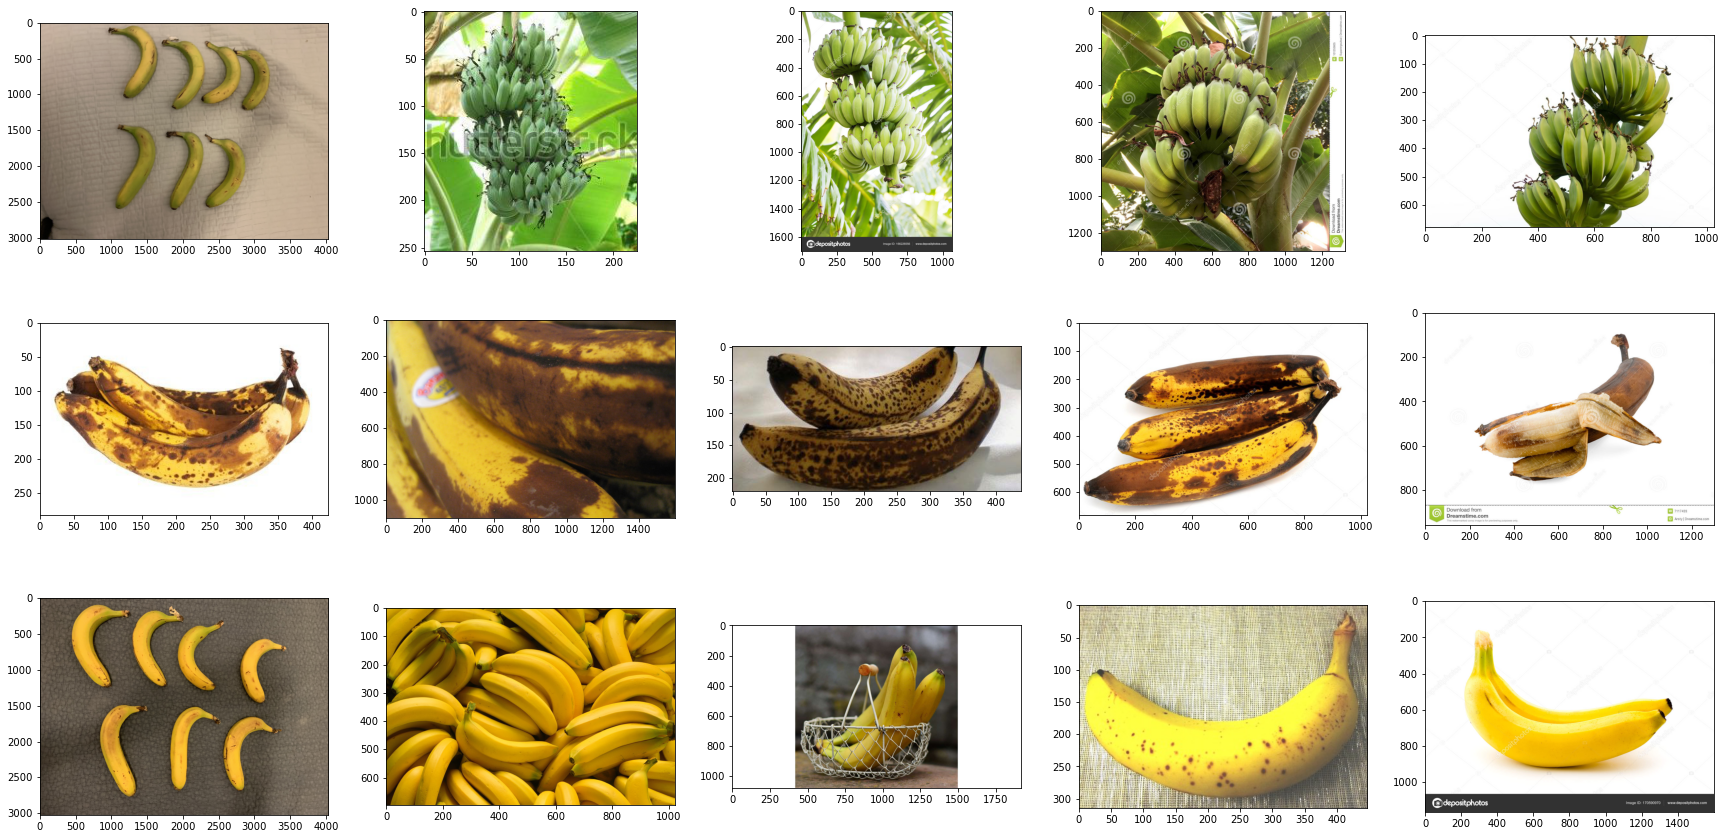

In [6]:
fig,ax = plt.subplots(3,5,figsize = (30,15))

for i,path in enumerate(green_files[:5]):
    ax[0,i].imshow(img.imread(path))
    
for i,path in enumerate(overripe_files[:5]):
    ax[1,i].imshow(img.imread(path))
    
for i,path in enumerate(ripe_files[:5]):
    ax[2, i].imshow(img.imread(path))


The first row shows the green, second row shows overripe and the third row shows the ripe bananas. Based on the images above, we can examine the following:

* Images have different sizes
* Images may have one to many bananas
* Different background colors
* Strong color differences between the classes.

It is a good sign that the dataset has different variances in the image. This allows the model to learn and generalize on images with different settings. 

## 3.0 Detect Bananas

In this section, we will use the pre-trained model to detect the bananas in the images.

The pre-trained models are a model that is previously trained on a large dataset, typically on a large-scale image classification tasks. 

We will firstly use VGG16 which is a common ImageNet developed by K.Simonyan and A. Zisserman from the University of Oxford. It is a pre-trained model with over 14 million images belonging to 1000 classes. The model is a 16 layer deep convolutional network with combinations of convolution and pooling layers. 

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### 3.1 Preprocessing the Image

Once we have the model, the next step is to transform the input image so that the model can predict from the iamge. The preprocessing step is already define as the model require a specific size and normalization. 

For transforming the data, we can simply use the `transforms` from `torchvision`.

In [8]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])


Line [1]: Here we are defining a variable transform which is a combination of all the image transformations to be carried out on the input image.

Line [2]: Resize the image to 256×256 pixels.

Line [3]: Crop the image to 224×224 pixels about the center.

Line [4]: Convert the image to PyTorch Tensor data type.

Line [5-7]: Normalize the image by setting its mean and standard deviation to the specified values.

### 3.2 Test the images

Now that we have the VGG16 model and the preprocessing step of the image, we will need to test how well the model is able to predict banana. 

We believe that predicting the banana object as the number one confidence level from 1000 classes may be a bit challenging. Instead, we will get the top 5 predictions from our model and if the banana is within the top 5, we will accept and say that the model predicted banana.

In [9]:
from PIL import Image
import json

#Labels of the index prediction from the model
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [10]:
def predict_banana(df, model):
    result = []
    model.eval()
    
    for path in df['Path']:
        banana = False
        img = Image.open(path)
        img_t = transform(img)
        batch_t = torch.unsqueeze(img_t, 0)
        out = model(batch_t)

        #If top 5 prediction contains banana, return True as banana
        for idx in out[0].sort(descending = True)[1][:5]:
            if 'banana' in idx2label[idx]:
                banana = True

        if banana:
            result.append(1)
        else:
            result.append(0)
            
    return result

In [11]:
result = predict_banana(df, VGG16)

In [12]:
sum(result)/len(result)

0.9213836477987422

### 3.3 Training with Other Architectures 
With VGG 16 model, we can correctly label banana 90% of the time. We will also explore other pre-trained architecture, restNet101 and see how that performs compared to VGG16. 

Based on the documentation of the torchvision models, https://pytorch.org/vision/stable/models.html, restNet101 outperforms the VGG16 for Accuracy@5 and also has significantly less model size. 

In [175]:
resnet = models.resnet101(pretrained=True)
resnet.eval()

In [177]:
result = predict_banana(df, resnet)

In [180]:
sum(result)/len(result)

0.9779874213836478

Even though the ResNet101 model requires less time and model size, it still outperforms VGG-16. We will use ResNet101 for our final model for prediction of banana object.

### 3.4 Other Object Detection

Now that we have the model for detecting the banana, we need to make sure that the model also predicts the images that are not banana. If the model detects other objects, we should stop the model for further analysis, because the model specifically takes in banana as an input. 

For validating the model, the fruit dataset from Kaggle is used. 

In [402]:
import random
#Get 2000 images from 20k images
notbanana = np.array(glob("data/notbanana/*/*"))
random.shuffle(notbanana)

notbanana = notbanana[:2000]

In [403]:
df_other = pd.DataFrame(notbanana,columns=['Path'])

In [404]:
result_VGG16 = predict_banana(df_other, VGG16)

In [405]:
1 - sum(result_VGG16)/len(result_VGG16)

0.996

In [406]:
result_resnet = predict_banana(df_other, resnet)

In [407]:
1 - sum(result_resnet)/len(result_resnet)

0.9955

The model is able to predict the non-banana objects quite well; however, the accuracy isn't as good as prediction of banana itself. This is considered to be okay, because what we find critical in this model is not predicting the banana as not banana (False Negative) than predicting the not-banana as banana (False Positive). We would like to make sure that the bananas are predicting as banana so that it can move onto the next stage of the model, which is predicting the ripeness. If we wanted to reduce the false positives, then we could have reduced the number of k terms in Acc@K metric. This would allow for less false positive, but more false negative.

# 4.0 Ripe Level Classification Baseline Model

After detecting the image of banana, we need a classification model for the ripeness of the banana. The plan for the implmentation is to develop a CNN model as our baseline model and explore other options  ImageNet

### 4.1 Train-Val-Test Split

Before we develop the model, we would need to split our dataset into train, validation and test set. 

In [13]:
import shutil
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df['label'] = LabelEncoder().fit_transform(df['class'])

df.head()

categories = {0:'green', 1:'overripe', 2:'ripe'}

df['file_name'] = [os.path.basename(x) for x in df['Path']]

#Split into train, test and validation set

X_train, X_test, y_train, y_test = train_test_split(df, df['label'], test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

For Pytorch dataloader, we actually need to format the directory tree as follows:

 * train
   * Green
   * Overripe
   * Ripe
 * test
   * Green
   * Overripe
   * Ripe
 * Validation
   * Green
   * Overripe
   * Ripe

In [114]:
for idx,row in X_train.iterrows():
    shutil.copy(row['Path'], "final_data/train/{}".format(categories[int(row['label'])]))
    
for idx,row in X_test.iterrows():
    shutil.copy(row['Path'], "final_data/test/{}".format(categories[int(row['label'])]))
    
for idx,row in X_val.iterrows():
    shutil.copy(row['Path'], "final_data/val/{}".format(categories[int(row['label'])]))


In [289]:
import os
from torchvision import datasets

data_dir = 'final_data'

batch_size = 16

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform)
valid_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform)
test_set = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=8, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, shuffle=True, batch_size=8, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_set,  shuffle=True, batch_size=8, num_workers=0)

loaders_scratch = {
    'train' : train_loader,
    'valid' : valid_loader,
    'test'  : test_loader
}


### 4.2 CNN Baseline Model

For our baseline or benchmark model, we will use simple 2 layer convolutional layer with three fully connected layers.

The foundation of many architectures including the ImageNets are from CNN. Hence, CNN is chosen as our baseline model. CNN has became one of the most popular algorithm for images, voice recognition, and even time series and text. Similar to how our brain interprets the image, convolutional layer seeks and extracts for specific aspects or areas to differentiate the images from one to another.

For selection of the hyperparameters such as the nodes output, we chose the parameters from the CNN example presented in the [PyTorch documentation](https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html)

Since the CNN model is for benchmarking, we will not train and deploy the model through SageMaker.

In [656]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # 224 x 224 x 3 tensor
        self.conv1 = nn.Conv2d(3, 6, 3, stride=2, padding=1)
        # 56 x 56 x 8 tensor
        self.conv2 = nn.Conv2d(6, 16, 3, stride=2, padding=1)
        # 14 x 14 x 16 tensor
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (16 * 7 * 7 -> 500)
        self.fc1 = nn.Linear(16 * 14 * 14, 120)
        # linear layer (500 -> 133)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_scratch = Net()

if use_cuda:
    model_scratch.cuda()


In [657]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

The script for training and testing the model has been taken from Udacity Capstone Project, [Dog Breed Classifier](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-dog-classification/dog_app.ipynb)

In [658]:
# this is to avoid running into the error: "OSError: image file is truncated (x bytes not processed)"
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [659]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
model_scratch = train(10, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))


Epoch: 1 	Training Loss: 1.089680 	Validation Loss: 1.060885
Validation loss decreased (inf --> 1.060885). Saving model...
Epoch: 2 	Training Loss: 1.070217 	Validation Loss: 1.017870
Validation loss decreased (1.060885 --> 1.017870). Saving model...
Epoch: 3 	Training Loss: 1.046586 	Validation Loss: 0.961943
Validation loss decreased (1.017870 --> 0.961943). Saving model...
Epoch: 4 	Training Loss: 1.012701 	Validation Loss: 0.913068
Validation loss decreased (0.961943 --> 0.913068). Saving model...
Epoch: 5 	Training Loss: 0.943886 	Validation Loss: 0.794792
Validation loss decreased (0.913068 --> 0.794792). Saving model...
Epoch: 6 	Training Loss: 0.831314 	Validation Loss: 0.595467
Validation loss decreased (0.794792 --> 0.595467). Saving model...
Epoch: 7 	Training Loss: 0.658717 	Validation Loss: 0.481289
Validation loss decreased (0.595467 --> 0.481289). Saving model...
Epoch: 8 	Training Loss: 0.533931 	Validation Loss: 0.316409
Validation loss decreased (0.481289 --> 0.316409

<All keys matched successfully>

In [660]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)


Test Loss: 0.446227


Test Accuracy: 80% (93/116)


The baseline has achieved the accuracy of 85%. We will try to fit a model that outperforms 

# 5.0 Ripeness Classification Model Implementation 

For implementation of the classification model, we will use the transfer learning model such as ResNet101 and ResNet152. We will firstly use ResNet152 and check its performance on test set. Then we will fit both ResNet101 and ResNet152 along with other hyperparameters to determine for the best performing architecture. 

The ResNet architecture is chosen, because of its superior performance while having minimal model size.

Similar the banana detection model we developed earlier, the transfer learning models are a pre-trained ImageNets that we train on top of. We need to modify the output layer of the architecture to our output layer with the correct dimensions. Additionally, we add two fully connected layers after the ImageNet architecture for the final prediction of our classes.

We will use PyTorch and SageMaker to train the model. Training with SageMaker allows us to utilize the GPU in the cloud and train in parallel for hyperparameter tuning.

In [376]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'udacity-capstone-project'

role = sagemaker.get_execution_role()

output_path = 's3://{}/{}/output'.format(bucket,prefix)

In [386]:
from sagemaker.pytorch import PyTorch, PyTorchModel

estimator = PyTorch(entry_point="train.py",
                    source_dir="source",
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    py_version="py3",
                    train_instance_type='ml.m4.xlarge',
                    hyperparameters={
                    'model_transfer': 'ResNet101',
                    'hidden_layer': 128,
                    'batch-size': 8,
                    'learning-rate': 0.01
                    })

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [387]:
data_channels = {"training": f"s3://{bucket}/{prefix}/"}

In [388]:
estimator.fit(data_channels)

2021-07-08 15:13:32 Starting - Starting the training job...
2021-07-08 15:13:35 Starting - Launching requested ML instancesProfilerReport-1625757212: InProgress
......
2021-07-08 15:15:01 Starting - Preparing the instances for training.........
2021-07-08 15:16:26 Downloading - Downloading input data...
2021-07-08 15:17:02 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-08 15:17:07,662 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-07-08 15:17:07,665 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-08 15:17:07,680 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-08 15:17:10,697 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-08 15:17:10,958 sagemaker-containers INFO     Module train does not provide a setup.py. 


Epoch: 1 #011Training Loss: 0.978830 #011Validation Loss: 0.858505
Validation loss decreased (inf --> 0.858505). Saving model...
Final Val Loss: 0.858505
Epoch: 2 #011Training Loss: 0.821816 #011Validation Loss: 0.686716
Validation loss decreased (0.858505 --> 0.686716). Saving model...
Final Val Loss: 0.686716
Epoch: 3 #011Training Loss: 0.649894 #011Validation Loss: 0.518631
Validation loss decreased (0.686716 --> 0.518631). Saving model...
Final Val Loss: 0.518631
Epoch: 4 #011Training Loss: 0.546169 #011Validation Loss: 0.454043
Validation loss decreased (0.518631 --> 0.454043). Saving model...
Final Val Loss: 0.454043
Epoch: 5 #011Training Loss: 0.507656 #011Validation Loss: 0.393834
Validation loss decreased (0.454043 --> 0.393834). Saving model...
Final Val Loss: 0.393834
Epoch: 6 #011Training Loss: 0.334467 #011Validation Loss: 0.332451
Validation loss decreased (0.393834 --> 0.332451). Saving model...
Final Val Loss: 0.332451
Epoch: 7 #011Training Loss: 0.377335 #011Validation

In [389]:
# TODO: Deploy the trained model
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------!

In [661]:
def get_accuracy(predictor, test_loader):
    test_loss = 0.
    correct = 0.
    total = 0.


    for batch_idx, (data, target) in enumerate(test_loader):
        output = predictor.predict(data)
        pred = np.argmax(output, axis =1)
        target = target.cpu().numpy()
        # compare predictions to true label
        correct += (pred == target).sum()
        total += data.size(0)

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))        

In [391]:
get_accuracy(predictor, test_loader)


Test Accuracy: 87% (101/116)


In [392]:
predictor.delete_endpoint()

Compared to the CNN model, the ResNet101 model outperforms with accuracy of 93%. We will also evaluate different parameters and architecture to seek for the best performing model.

## 5.1 Hyperparameter Tuning

The hyperparameter of the models are as follows:

* ImageNet: [ResNet101, ResNet152]
* Hidden dimension: hidden dimension of the fully connected layer.
* Batch Size: batch size per gradient updates
* Epochs: number of training iteration
* Learning Rate: update rate of the coefficients

In [664]:
from sagemaker.tuner import HyperparameterTuner,ContinuousParameter,CategoricalParameter

hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([8, 16, 32]),
    "model_transfer": CategoricalParameter(['ResNet101', 'ResNet152']),
    'hidden_layer': CategoricalParameter([128, 256, 512]),
}

In [670]:
objective_metric_name = "val loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "val loss", "Regex": "Final Val Loss: ([0-9\\.]+)"}]

In [666]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=12,
    max_parallel_jobs=3,
    objective_type=objective_type,
)


In [ ]:
tuner.fit(data_channels)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [674]:
tuner.best_training_job()

'sagemaker-pytorch-210708-2243-010-760ae3f4'

## 5.2 Test the Final Model

In [678]:
#Deploy the best performing model
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")


2021-07-09 01:55:01 Starting - Preparing the instances for training
2021-07-09 01:55:01 Downloading - Downloading input data
2021-07-09 01:55:01 Training - Training image download completed. Training in progress.
2021-07-09 01:55:01 Uploading - Uploading generated training model
2021-07-09 01:55:01 Completed - Training job completed
-----------------!

In [679]:
get_accuracy(predictor, test_loader)


Test Accuracy: 93% (109/116)


In [680]:
predictor.delete_endpoint()

# 6.0 Final Implementation

In [681]:
tuner.best_training_job()

'sagemaker-pytorch-210708-2243-010-760ae3f4'

In [682]:
estimator_attached = sagemaker.estimator.Estimator.attach(tuner.best_training_job())


2021-07-09 01:55:01 Starting - Preparing the instances for training
2021-07-09 01:55:01 Downloading - Downloading input data
2021-07-09 01:55:01 Training - Training image download completed. Training in progress.
2021-07-09 01:55:01 Uploading - Uploading generated training model
2021-07-09 01:55:01 Completed - Training job completed


In [683]:
estimator_attached.hyperparameters()

{'_tuning_objective_metric': 'val loss',
 'batch-size': '"8"',
 'hidden_layer': '"128"',
 'learning-rate': '0.02527216658788655',
 'model_transfer': '"ResNet101"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"sagemaker-pytorch-2021-07-08-22-43-16-754"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-941631403658/sagemaker-pytorch-2021-07-08-22-43-16-754/source/sourcedir.tar.gz"'}

In [684]:
model = PyTorchModel(model_data=estimator_attached.model_data,
                     role = role,
                     framework_version='1.0',
                     py_version="py3",
                     entry_point='predict.py',
                     source_dir='source')

In [685]:
predictor = model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-------------!

In [686]:
def predict_banana(df, model):
    result = []
    model.eval()
    
    for path in df['Path']:
        banana = False
        img = Image.open(path)
        img_t = transform(img)
        batch_t = torch.unsqueeze(img_t, 0)
        out = model(batch_t)

        #If top 5 prediction contains banana, return True as banana
        for idx in out[0].sort(descending = True)[1][:5]:
            if 'banana' in idx2label[idx]:
                banana = True

        if banana:
            result.append(1)
        else:
            result.append(0)
            
    return result

In [687]:
def lambda_function(class_model, path, object_model):
    banana = False

    img = Image.open(path)
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    out = object_model(batch_t)
    
    
    for idx in out[0].sort(descending = True)[1][:5]:
            if 'banana' in idx2label[idx]:
                banana = True
        
    if not banana:
        top_pred_idx = out[0].sort(descending = True)[1][0]
        print("This is not banana! This looks like {} 🤔🤔".format(idx2label[top_pred_idx]))
        print("Please upload banana for classification")
        
    else:
        out = class_model.predict(batch_t)
        final_pred = np.argmax(out)
        
        if final_pred ==0:
            print("This banana is Unripe!! 🤮🤮")
            
        elif final_pred ==1:
            print("This banana is Overripe!! 🤮🤮")
        else:
            print("This banana is Ripe!! 🚀🚀")
        
        
    plt.imshow(img)
    plt.show()

This is not banana! This looks like pineapple 🤔🤔
Please upload banana for classification


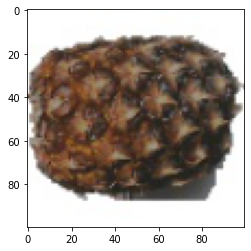

In [688]:
lambda_function(predictor, notbanana[55], resnet)

This is not banana! This looks like strawberry 🤔🤔
Please upload banana for classification


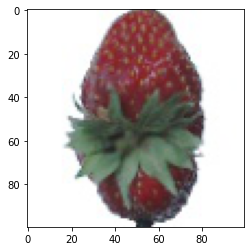

In [689]:
lambda_function(predictor, notbanana[700], resnet)

This banana is Unripe!! 🤮🤮


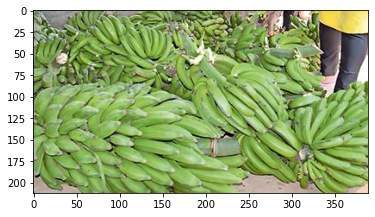

In [690]:
lambda_function(predictor, df['Path'][50], resnet)

This banana is Unripe!! 🤮🤮


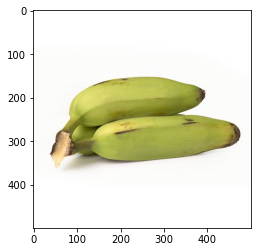

In [691]:
lambda_function(predictor, df['Path'][100], resnet)

This banana is Overripe!! 🤮🤮


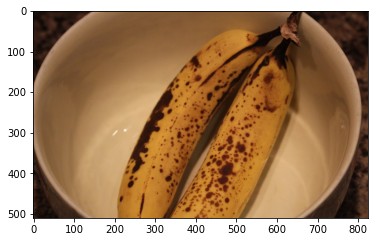

In [692]:
lambda_function(predictor, df['Path'][155], resnet)

This banana is Overripe!! 🤮🤮


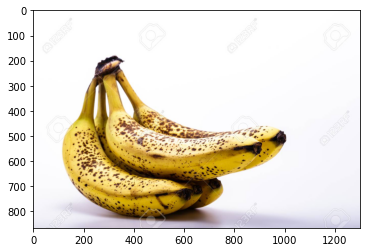

In [693]:
lambda_function(predictor, df['Path'][160], resnet)

This banana is Ripe!! 🚀🚀


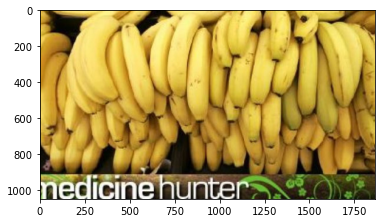

In [694]:
lambda_function(predictor, df['Path'][200], resnet)

This banana is Ripe!! 🚀🚀


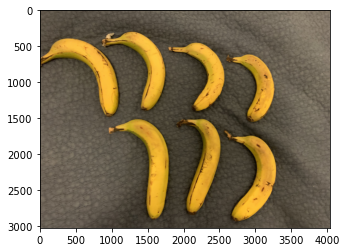

In [695]:
lambda_function(predictor, df['Path'][225], resnet)

## Clean up Resources

In [ ]:
predictor.delete_endpoint()